In [1]:
import pyro
import torch
import numpy as np
from chirho.dynamical.ops import State, simulate
from chirho.dynamical.handlers.solver import TorchDiffEq
from chirho.dynamical.handlers import LogTrajectory
import matplotlib.pyplot as plt
import seaborn as sns

/Users/archana/opt/anaconda3/envs/CHIRHO/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class SimpleSlimeDynamics(pyro.nn.PyroModule):

    # About the model
    # B:     the number of spatial bins
    # D:     the density of slime mold agents
    # P:     the density of pheromones
    # dD/dt: slime mold follows pheromones
    # dP/dt: pheromones are deposited by slime mold, then diffuse
    # alpha: pheromone deposition rate
    # beta:  pheromone diffusion rate
    # r:     slime mold following rate

    def __init__(self, B, alpha, beta, r):
        super().__init__()
        self.B = B
        self.alpha = alpha / B
        self.beta = beta / B
        self.r = r / B

    @pyro.nn.pyro_method
    def diff(self, dstate: State[torch.Tensor], state: State[torch.Tensor]) -> None:
        deposition_term = self.alpha * state["D"]
        diffusion_term = self.beta * (torch.roll(state["P"], 1) + torch.roll(state["P"], -1) - 2 * state["P"])

        pheromone_right = torch.relu(torch.roll(state["P"], 1) - state["P"])
        pheromone_left = torch.relu(torch.roll(state["P"], -1) - state["P"])
        slime_flux_right = self.r * pheromone_right * state["D"]
        slime_flux_left = self.r * pheromone_left * state["D"]

        dstate["D"] = torch.roll(slime_flux_right, -1) - slime_flux_right
        dstate["D"] += torch.roll(slime_flux_left, 1) - slime_flux_left
        dstate["P"] = deposition_term + diffusion_term


    def forward(self, state: State[torch.Tensor]):
        dstate = State()
        self.diff(dstate, state)
        return dstate

In [3]:
# Generate model paramters for a given number of bins
def generate_parameters(B):
    alpha = torch.tensor(0.1) * B
    beta = torch.tensor(0.1) * B
    r = torch.tensor(1.) * B
    return alpha, beta, r

In [4]:
# Initial state for the high resolution (B = 256) model
# initial D is a torch array of size B
B = torch.tensor(256)
alpha, beta, r = generate_parameters(B)
model = SimpleSlimeDynamics(B, alpha, beta, r)
with pyro.plate("bins", B):
    D_initial = pyro.sample("D_initial", pyro.distributions.Uniform(0, 1))
    P_initial = pyro.sample("P_initial", pyro.distributions.Uniform(0, .1))

initial_state = State(D=D_initial, P=P_initial)
start_time = torch.tensor(0.0)
end_time = torch.tensor(50.0)
step_size = torch.tensor(0.1)
trajectory_times = torch.arange(start_time+step_size, end_time, step_size)


In [5]:
# Simulation of the high resolution model
with LogTrajectory(trajectory_times) as lt:
    final_state = simulate(model, initial_state, start_time, end_time, solver=TorchDiffEq())

trajectory = lt.trajectory

In [6]:
# Initial states for lower resolution models:
B_low = [256, 128, 64, 32, 16, 8, 4]
D_initial_low = [torch.tensor([sum(D_initial[i:i+int(B/b)]) for i in range(0, B, int(B/b))]) for b in B_low]
P_initial_low = [torch.tensor([sum(P_initial[i:i+int(B/b)]) for i in range(0, B, int(B/b))]) for b in B_low]

In [7]:
# Simulate lower resolution models
trajectories_low = []
for i in range(len(B_low)):
    b = torch.tensor(B_low[i])
    alpha, beta, r = generate_parameters(b)
    model = SimpleSlimeDynamics(b, alpha, beta, r)
    initial_state = State(D=D_initial_low[i], P=P_initial_low[i])
    with LogTrajectory(trajectory_times) as lt:
        final_state = simulate(model, initial_state, start_time, end_time, solver=TorchDiffEq())
    trajectories_low.append(lt.trajectory)

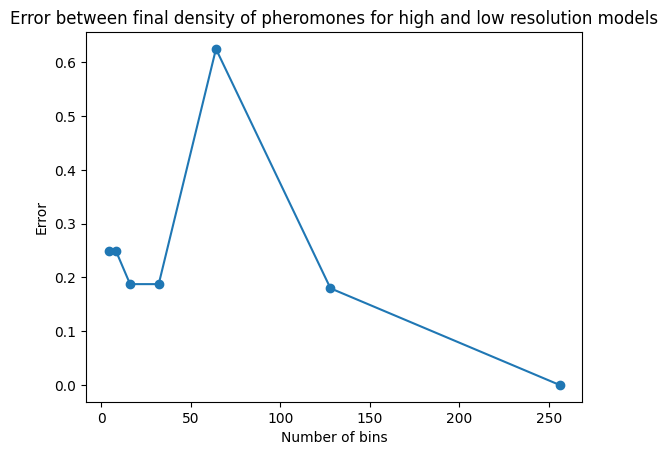

In [9]:
# Plotting the euclidean distance between final 'P' in the high resolution model and the low resolution models:
errs = []
for i in range(len(B_low)):
    arg_high = trajectory['P'][:,-1].argmax()
    arg_low = trajectories_low[i]['P'][:,-1].argmax()
    errs.append(abs(np.floor(arg_high/(B/B_low[i])) - arg_low)/B_low[i])

plt.plot(B_low, errs, '-o')
plt.title('Error between final density of pheromones for high and low resolution models')
plt.xlabel('Number of bins')
plt.ylabel('Error')
plt.show()

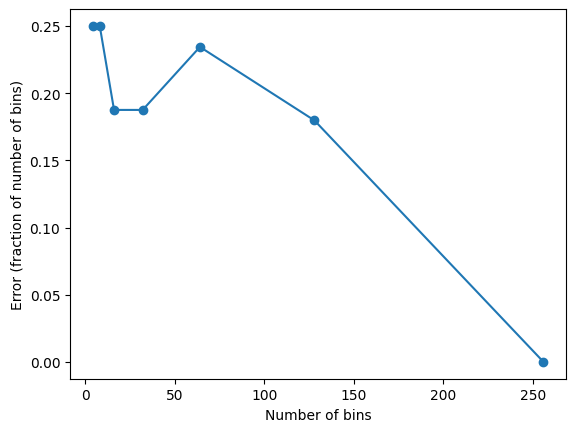

In [12]:
# Query 1
errs = []
for i in range(len(B_low)):
    arg_high = trajectory['D'][:,-1].argmax()
    arg_low = trajectories_low[i]['D'][:,-1].argmax()
    errs.append(abs(np.floor(arg_high/(B/B_low[i])) - arg_low)/B_low[i])

# Error between final density of slime mold for high and low resolution models
plt.plot(B_low, torch.tensor(errs), '-o')
# plt.title('')
plt.xlabel('Number of bins')
plt.ylabel('Error (fraction of number of bins)')
plt.show()

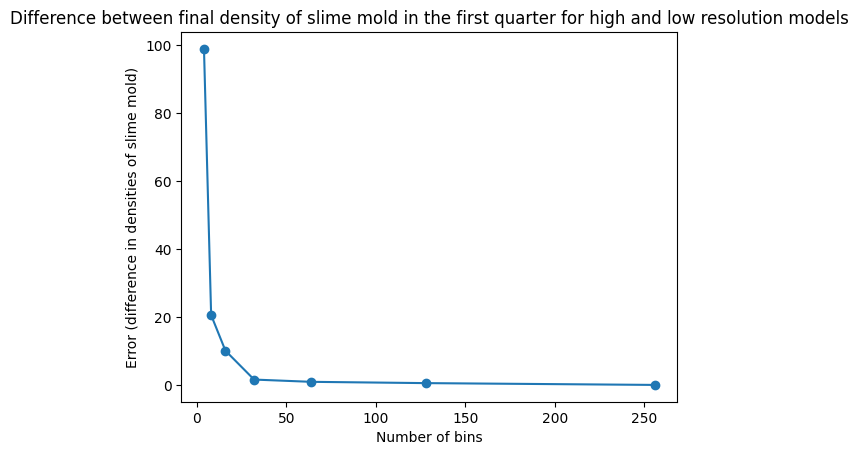

In [11]:
# Query 2
errs = []
amt_in_first_quarter = trajectory['D'][0:64, -1].sum()
for i in range(len(B_low)):
    errs.append(abs(trajectories_low[i]['D'][0:int(B_low[i]/4), -1].sum() - amt_in_first_quarter))

# Error between final density of slime mold for high and low resolution models
plt.plot(B_low, errs, '-o')
plt.title('Difference between final density of slime mold in the first quarter for high and low resolution models')

# plt.suptitle('alpha = 0.5, beta = 0.01, r = 10')
plt.xlabel('Number of bins')
plt.ylabel('Error (difference in densities of slime mold)')
plt.show()

In [ ]:
# # Extracting D and P from the trajectory
# D_trajectory = trajectory["D"]
# P_trajectory = trajectory["P"]

# # Time points
# time_points = trajectory_times.numpy()

# # Plotting
# plt.figure(figsize=(12, 6))

# # Plotting D, as a function of space
# plt.subplot(1, 2, 1)
# for t in range(len(time_points)):
#     plt.plot(D_trajectory[:,t], label="t={}".format(time_points[t]))
# plt.xlabel('position')
# plt.ylabel('density of slime mold')

# # Plotting P, as a function of space
# plt.subplot(1, 2, 2)
# for t in range(len(time_points)):
#     plt.plot(P_trajectory[:,t], label="t={}".format(time_points[t]))
# plt.xlabel('position')
# plt.ylabel('density of pheromones')


# # Plotting
# plt.figure(figsize=(12, 6))

# # Heatmap for D
# plt.subplot(1, 2, 1)
# sns.heatmap(D_trajectory, cmap="viridis", xticklabels=10, yticklabels=5, cbar_kws={'label': 'Density of Slime Mold'})
# plt.title('Heatmap of Slime Mold Density (D) over Time')
# plt.xlabel('Time Step')
# plt.ylabel('Bin')

# # Heatmap for P
# plt.subplot(1, 2, 2)
# sns.heatmap(P_trajectory, cmap="magma", xticklabels=10, yticklabels=5, cbar_kws={'label': 'Density of Pheromones'})
# plt.title('Heatmap of Pheromone Density (P) over Time')
# plt.xlabel('Time Step')
# plt.ylabel('Bin')

# plt.tight_layout()
# plt.show()